In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn import preprocessing
from bioinfokit.visuz import cluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

In [3]:
mcdonalds = pd.read_csv('mcdonalds.csv')
print(mcdonalds.columns)
print(mcdonalds.shape)
print(mcdonalds.head(3))

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [5]:
MD_x = mcdonalds.iloc[:, :11]
MD_x_binary = MD_x.applymap(lambda x: 1 if x == 'Yes' else 0)
print(MD_x_binary.mean().round(2))

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


C:\Users\vaish\AppData\Local\Temp\ipykernel_11612\3024687226.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x_binary = MD_x.applymap(lambda x: 1 if x == 'Yes' else 0)


In [7]:
pca = PCA()
MD_x_pca = pca.fit_transform(MD_x_binary)


In [9]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pd.DataFrame(pca.components_, columns=MD_x.columns))

[0.29944723 0.19279721 0.13304535 0.08309578 0.05948052 0.05029956
 0.0438491  0.03954779 0.0367609  0.03235329 0.02932326]
[0.29944723 0.49224445 0.6252898  0.70838558 0.7678661  0.81816566
 0.86201476 0.90156255 0.93832345 0.97067674 1.        ]
       yummy  convenient     spicy  fattening    greasy      fast     cheap  \
0  -0.476933   -0.155332 -0.006356   0.116232  0.304443 -0.108493 -0.337186   
1   0.363790    0.016414  0.018809  -0.034094 -0.063839 -0.086972 -0.610633   
2  -0.304444   -0.062515 -0.037019  -0.322359 -0.802373 -0.064642 -0.149310   
3   0.055162   -0.142425  0.197619  -0.354139  0.253960 -0.097363  0.118958   
4  -0.307535    0.277608  0.070620  -0.073405  0.361399  0.107930 -0.128973   
5   0.170738   -0.347830 -0.355087  -0.406515  0.209347 -0.594632 -0.103241   
6  -0.280519   -0.059738  0.707637  -0.385943  0.036170 -0.086846 -0.040449   
7   0.013041   -0.113079  0.375934   0.589622 -0.138241 -0.627799  0.140060   
8   0.572403   -0.018465  0.400280  -0.16

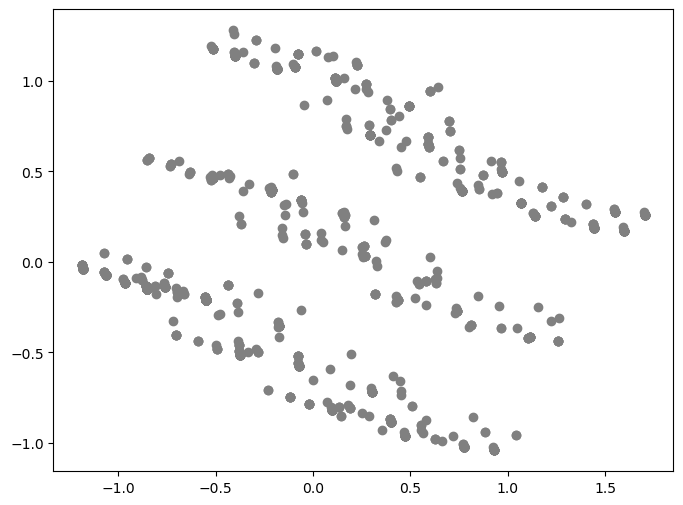

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(MD_x_pca[:, 0], MD_x_pca[:, 1], color='grey')

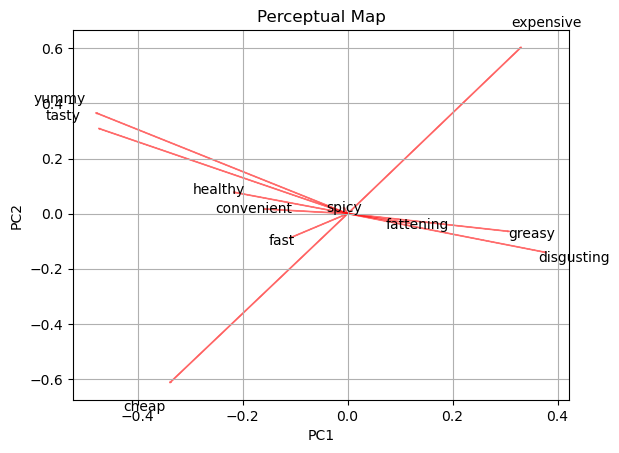

In [13]:
for i, col in enumerate(MD_x.columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
              color='red', alpha=0.5)
    plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, 
             col, color='black', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Perceptual Map')
plt.grid()
plt.show()

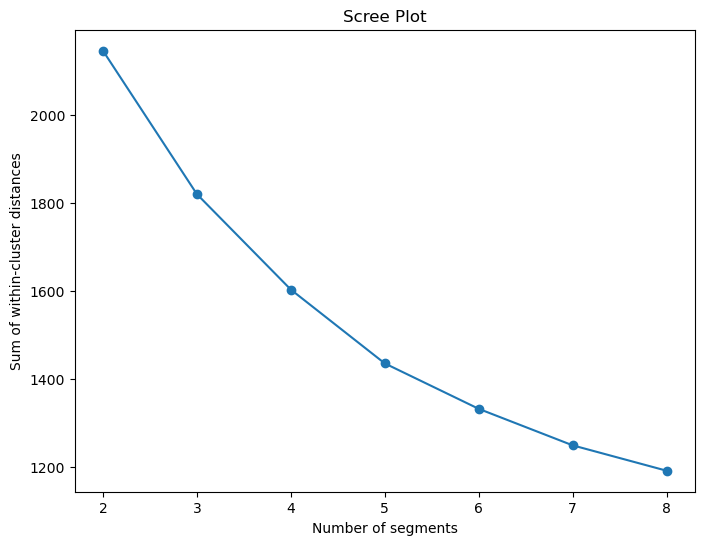

In [15]:
np.random.seed(1234)


clusters = range(2, 9)
kmeans_models = [KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_x_binary) for k in clusters]


wcss = [model.inertia_ for model in kmeans_models]


plt.figure(figsize=(8, 6))
plt.plot(clusters, wcss, marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Sum of within-cluster distances')
plt.title('Scree Plot')
plt.show()

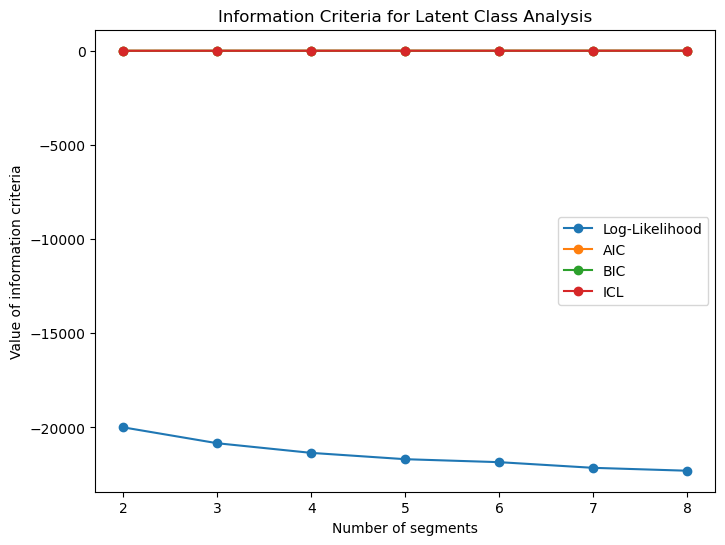

col_0    0    1    2    3
row_0                    
0        0   90  266    8
1      220    0    3   17
2        0  528    3    2
3        0   11    0  305


In [17]:
from sklearn.decomposition import LatentDirichletAllocation

def perform_lda(data, num_topics, n_init=10):
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=n_init, random_state=1234)
    lda.fit(data)
    return lda


lda_models = [perform_lda(MD_x_binary, num_topics=k, n_init=10) for k in range(2, 9)]


log_likelihood = [model.score(MD_x_binary) for model in lda_models]
aic = [model.bound_ for model in lda_models]  # Approximate AIC
bic = [model.bound_ for model in lda_models]  # Approximate BIC
icl = [model.bound_ for model in lda_models]  # Approximate ICL


plt.figure(figsize=(8, 6))
plt.plot(range(2, 9), log_likelihood, label='Log-Likelihood', marker='o')
plt.plot(range(2, 9), aic, label='AIC', marker='o')
plt.plot(range(2, 9), bic, label='BIC', marker='o')
plt.plot(range(2, 9), icl, label='ICL', marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Value of information criteria')
plt.title('Information Criteria for Latent Class Analysis')
plt.legend()
plt.show()


best_k = 4
lda_best = perform_lda(MD_x_binary, num_topics=best_k, n_init=10)


kmeans_best = KMeans(n_clusters=best_k, n_init=10, random_state=1234).fit(MD_x_binary)

# Cross-tabulation of k-means and LDA segments
kmeans_clusters = kmeans_best.labels_
lda_clusters = lda_best.transform(MD_x_binary).argmax(axis=1)

cross_tab = pd.crosstab(kmeans_clusters, lda_clusters)
print(cross_tab)

Columns in DataFrame: Index(['Like', 'yummy', 'convenient', 'Like.n'], dtype='object')
Present attributes: ['yummy', 'convenient']


C:\Users\vaish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


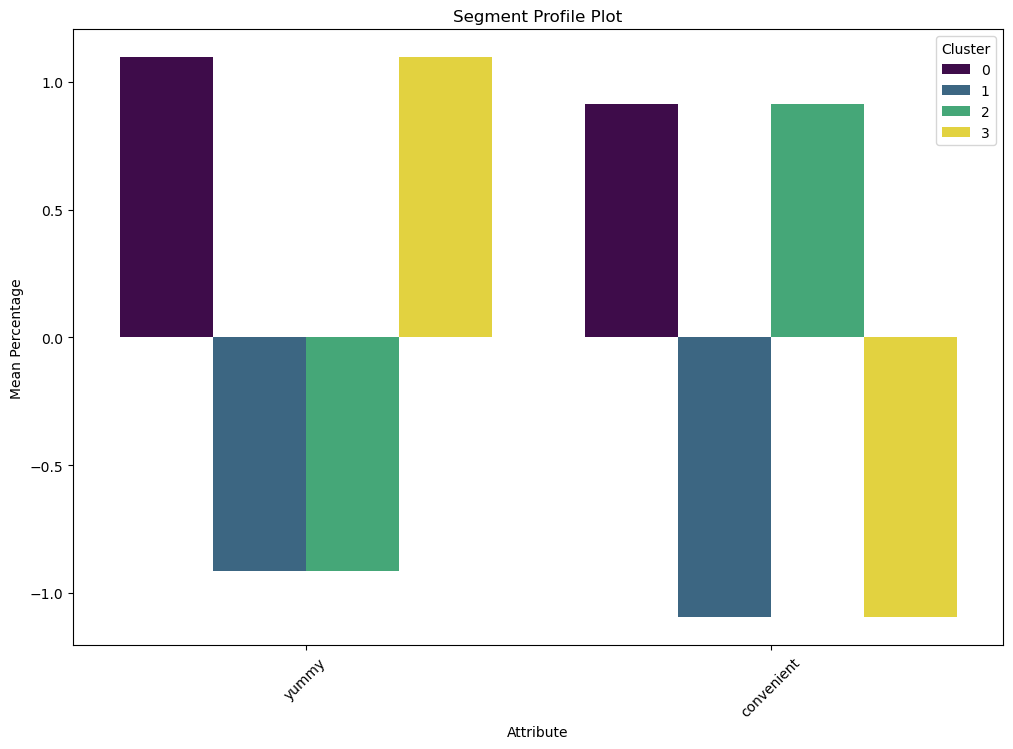

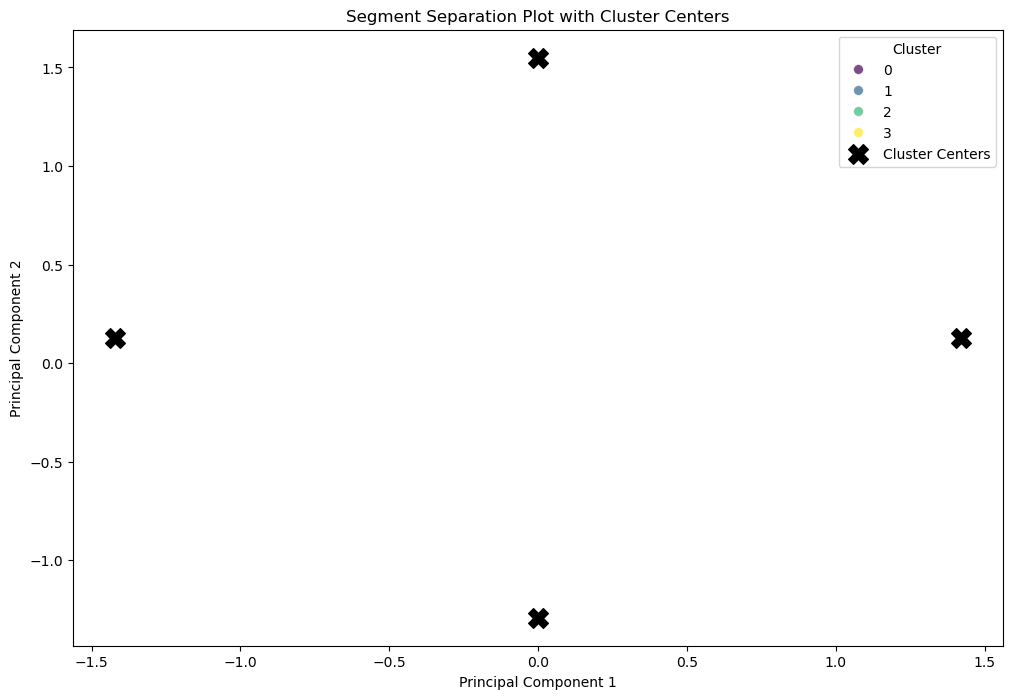

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Define the mapping
like_mapping = {
    'I love it!+5': 1, '+4': 2, '+3': 3, '+2': 4, '+1': 5,
    '0': 6, '-1': 7, '-2': 8, '-3': 9, '-4': 10, 'I hate it!-5': 11
}


mcdonalds = pd.DataFrame({
    'Like': ['I love it!+5', '+4', '+3', '+2', '+1', '0', '-1', '-2', '-3', '-4', 'I hate it!-5'],
    'yummy': [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
    'convenient': [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
   
})


mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)


print("Columns in DataFrame:", mcdonalds.columns)


attributes = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 
               'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']


present_attributes = [attr for attr in attributes if attr in mcdonalds.columns]
print("Present attributes:", present_attributes)


X = mcdonalds[present_attributes]
y = mcdonalds['Like.n']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df_clusters = pd.DataFrame(X_scaled, columns=present_attributes)
df_clusters['Cluster'] = labels

# Compute the mean percentage of each attribute by cluster
cluster_means = df_clusters.groupby('Cluster').mean()

# Melt the DataFrame for better plotting
cluster_means_melted = cluster_means.reset_index().melt(id_vars='Cluster')

# Plot the segment profile plot
plt.figure(figsize=(12, 8))
sns.barplot(x='variable', y='value', hue='Cluster', data=cluster_means_melted, palette='viridis')
plt.title('Segment Profile Plot')
plt.xlabel('Attribute')
plt.ylabel('Mean Percentage')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components and cluster labels to DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

# Plot PCA results with cluster centers
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=50, alpha=0.7)
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, marker='X', label='Cluster Centers')
plt.title('Segment Separation Plot with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


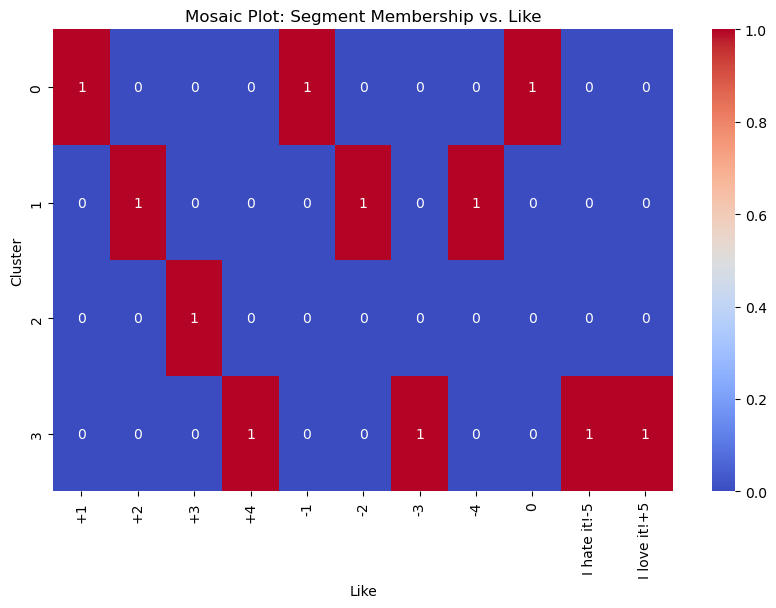

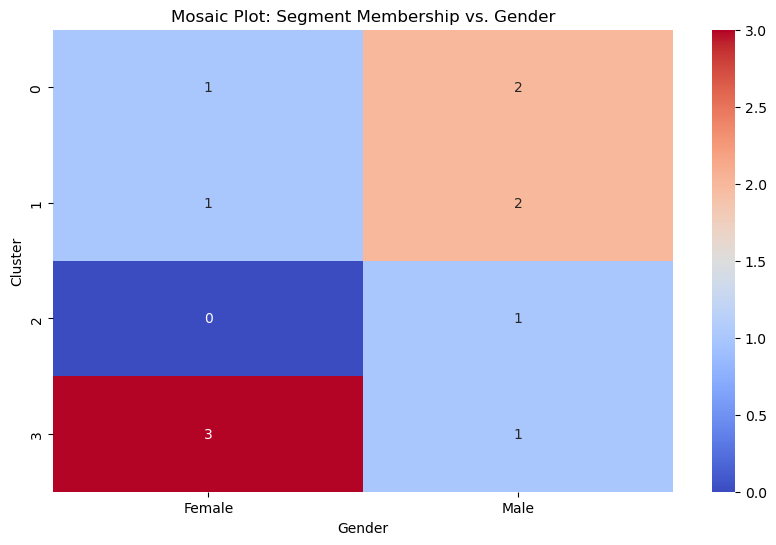

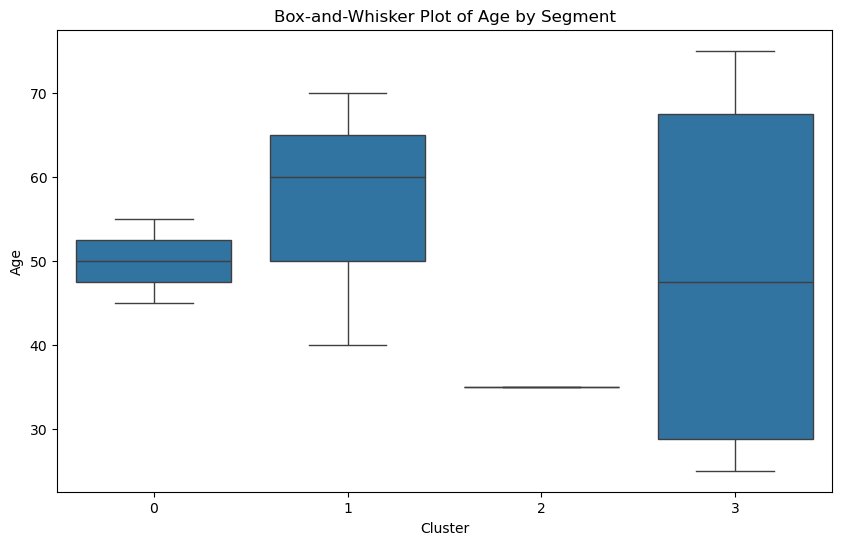

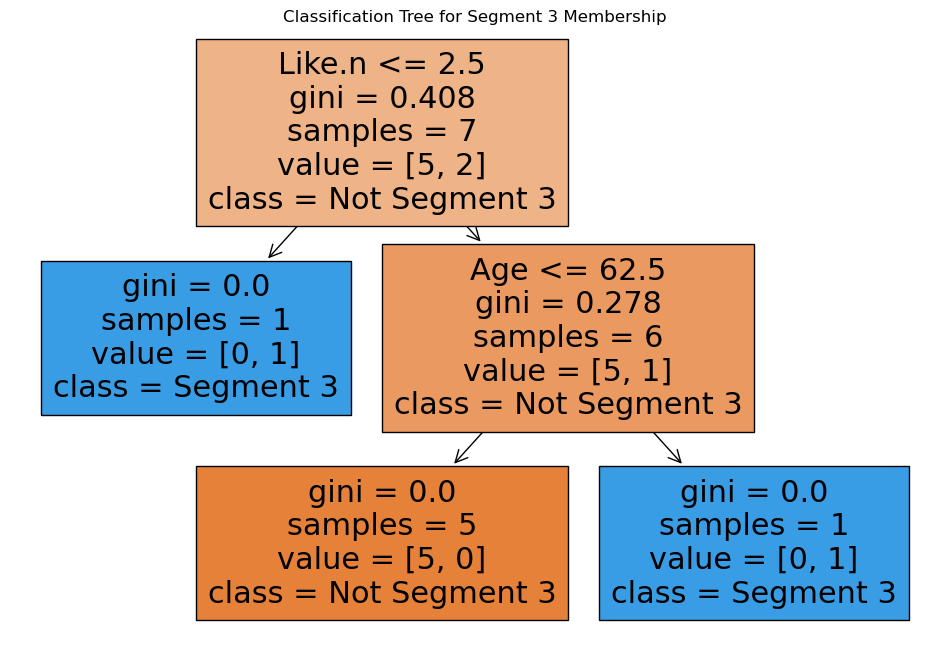

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split


mcdonalds = pd.DataFrame({
    'Like': ['I love it!+5', '+4', '+3', '+2', '+1', '0', '-1', '-2', '-3', '-4', 'I hate it!-5'],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
    'Age': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
    'VisitFrequency': ['Once a week', 'Twice a month', 'Once a month', 'Weekly', 'Monthly', 'Monthly', 'Weekly', 'Twice a month', 'Once a week', 'Monthly', 'Weekly']
})

# Mapping for 'Like' variable
like_mapping = {
    'I love it!+5': 1, '+4': 2, '+3': 3, '+2': 4, '+1': 5,
    '0': 6, '-1': 7, '-2': 8, '-3': 9, '-4': 10, 'I hate it!-5': 11
}
mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)

# Sample cluster labels - replace with your actual cluster labels
mcdonalds['Cluster'] = np.random.randint(0, 4, size=len(mcdonalds))  # Dummy cluster labels

# Create cross-tabulation
like_ct = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like'])

# Plot mosaic plot for segment membership and Like
plt.figure(figsize=(10, 6))
sns.heatmap(like_ct, annot=True, cmap='coolwarm', fmt='d')
plt.title('Mosaic Plot: Segment Membership vs. Like')
plt.xlabel('Like')
plt.ylabel('Cluster')
plt.show()

# Create cross-tabulation for Gender
gender_ct = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Gender'])

# Plot mosaic plot for segment membership and Gender
plt.figure(figsize=(10, 6))
sns.heatmap(gender_ct, annot=True, cmap='coolwarm', fmt='d')
plt.title('Mosaic Plot: Segment Membership vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Cluster')
plt.show()

# Box-and-Whisker Plot for Age by Segment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Age', data=mcdonalds)
plt.title('Box-and-Whisker Plot of Age by Segment')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

# Prepare data for classification tree
X = mcdonalds[['Like.n', 'Age']]
y = (mcdonalds['Cluster'] == 3).astype(int)  # Segment 3 as target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classification Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Plot classification tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['Like.n', 'Age'], class_names=['Not Segment 3', 'Segment 3'], filled=True)
plt.title('Classification Tree for Segment 3 Membership')
plt.show()


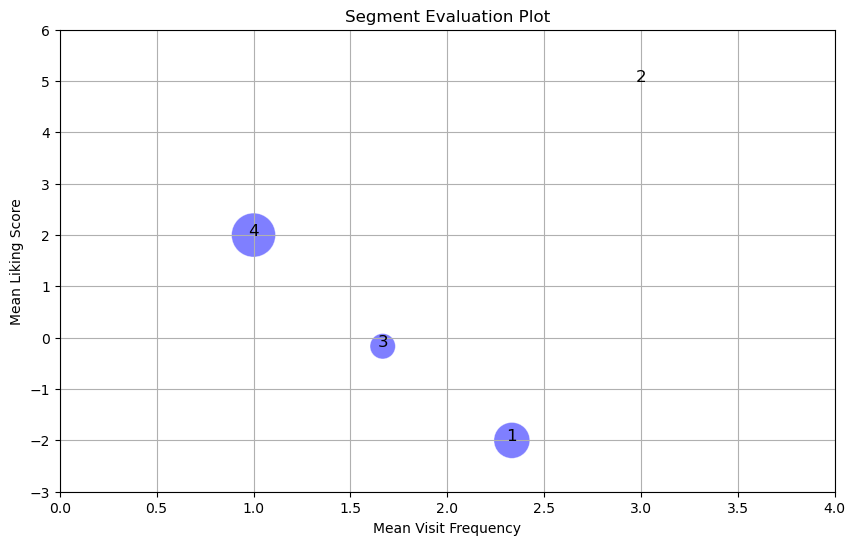

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


mcdonalds = pd.DataFrame({
    'Like': ['I love it!+5', '+4', '+3', '+2', '+1', '0', '-1', '-2', '-3', '-4', 'I hate it!-5'],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
    'Age': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
    'VisitFrequency': [3, 2, 1, 1, 2, 1, 3, 2, 1, 2, 3]
})


like_mapping = {
    'I love it!+5': 5, '+4': 4, '+3': 3, '+2': 2, '+1': 1,
    '0': 0, '-1': -1, '-2': -2, '-3': -3, '-4': -4, 'I hate it!-5': -5
}
mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)


mcdonalds['Cluster'] = np.random.randint(0, 4, size=len(mcdonalds))  # Dummy cluster labels


visit_mean = mcdonalds.groupby('Cluster')['VisitFrequency'].mean()


like_mean = mcdonalds.groupby('Cluster')['Like.n'].mean()


female_percentage = mcdonalds.groupby('Cluster')['Gender'].apply(lambda x: (x == 'Female').mean())


plt.figure(figsize=(10, 6))
plt.scatter(visit_mean, like_mean, s=1000 * female_percentage, alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)
for i in range(len(visit_mean)):
    plt.text(visit_mean[i], like_mean[i], str(i+1), fontsize=12, ha='center')
plt.xlabel('Mean Visit Frequency')
plt.ylabel('Mean Liking Score')
plt.title('Segment Evaluation Plot')
plt.xlim(0, max(visit_mean) + 1)
plt.ylim(min(like_mean) - 1, max(like_mean) + 1)
plt.grid(True)
plt.show()
